# Table of Contents

> This report/README is a direct export from the [README.ipynb](/README.ipynb) for better readability.

> The original interactive Jupyter Notebook shall be viewed in text editor equipped with Jupyter Notebook extentions, or Jupyter Notebook, or Jupyter Lab.


- [Table of Contents](#table-of-contents)
- [CODE](#code)
  - [Pre-requisites](#pre-requisites)
  - [Setup](#setup)
  - [Constant rates](#constant-rates)
  - [Variable input rate](#variable-input-rate)
- [REPORT](#report)
  - [Simulation description](#simulation-description)
  - [Plots](#plots)
  - [Discussion](#discussion)

# CODE

## Pre-requisites

- Python 3.11
- Jupyter Notebook (or equivalent)
- Python environment setup via `pip install -r requirements.txt`

## Setup

In [1]:
import os
import random

DEBUG = False
random.seed(0)
## Create directories figure & simulated_data
os.makedirs("figure", exist_ok=True)
os.makedirs("simulated_data", exist_ok=True)

## Discrete event simulator core

this is the heart of the simulation, a python implementation of the `Algorithm 1` in `project_1_requirement.pdf`

In [2]:
def simulate_event(
    pkt_in_q: int,
    pkt_dropped: int,
    arrival_rate: int,
    departure_rate: int,
    buffer_size: int,
) -> tuple[int, int]:
    y = random.random()
    # Either arrival or departure event
    if y < (arrival_rate / (departure_rate + arrival_rate)):
        # Arrival event
        if pkt_in_q < buffer_size:
            # Buffer is not full, accept packet
            pkt_in_q += 1
        else:
            # Buffer is full, drop packet
            pkt_dropped += 1
    else:
        # Departure event
        if pkt_in_q > 0:
            # Buffer is not empty, remove packet
            pkt_in_q -= 1
    return pkt_in_q, pkt_dropped

## Constant rates

In [3]:
def simulate_constant_events(
    arrival_rate: int, departure_rate: int, buffer_size: int, num_events: int
):
    # Initialize variables/counters related to the queue status.
    pkt_in_q = 0
    pkt_dropped = 0
    output_file = f"simulated_data/cr_{arrival_rate}_{departure_rate}_{buffer_size}.txt"

    # Write the header to the output file
    file = open(output_file, "w")
    file.write("event_seq, pkt_in_q, pkt_dropped\n")

    # Simulating the events for the specified number of times
    for event_seq in range(1, num_events + 1):
        # Update the queue status after each event
        pkt_in_q, pkt_dropped = simulate_event(
            pkt_in_q, pkt_dropped, arrival_rate, departure_rate, buffer_size
        )

        # Write results to the specified output file
        file.write(f"{event_seq} {pkt_in_q} {pkt_dropped}\n")
    file.close()
    if DEBUG:
        print(f"Simulation completed. Results are written to {output_file}")

The rates provided in the requirement are, all 27 combinations of the following:

|arrival (pkt/s)|departure (pkt/s)| buffer size (pkt)|
|-|-|-|
|30|50|50|
|80|100|100|
|120|120|150|

In [4]:
arrivals = [30, 80, 120]
departures = [50, 100, 120]
buffers = [50, 100, 150]

total_events = 1000000

# Iterate through all combinations of arrivals, departures and buffer sizes
for a in arrivals:
    for d in departures:
        for b in buffers:
            simulate_constant_events(a, d, b, total_events)

## Variable input rate

In [5]:
def simulate_variable_input_events(
    arrival_rates: list[tuple[int, int]],
    departure_rate: int,
    buffer_size: int,
    num_events: int,
):
    # Initialize variables/counters related to the queue status.
    pkt_in_q = 0
    pkt_dropped = 0
    output_file = f"simulated_data/vir_x_{departure_rate}_{buffer_size}.txt"
    event_seq = 1

    # Write the header to the output file
    file = open(output_file, "w")
    file.write("event_seq, pkt_in_q, pkt_dropped\n")

    for event_percentage, arrival_rate in arrival_rates:
        more_events = int(num_events * event_percentage / 100)

        if DEBUG:
            print(event_seq, more_events, event_percentage, arrival_rate)

        for event_seq in range(event_seq, event_seq + more_events):
            # Simulate the event
            pkt_in_q, pkt_dropped = simulate_event(
                pkt_in_q, pkt_dropped, arrival_rate, departure_rate, buffer_size
            )

            # Write results to the specified output file
            file.write(f"{event_seq} {pkt_in_q} {pkt_dropped}\n")
            event_seq += 1

    file.close()
    if DEBUG:
        print(f"Simulation completed. Results are written to {output_file}")

Original: 
|Events (%)| arrival (pkt/s)|
|-|-|
|0~10|70|
|10~70|200|
|70~80|130|
|80~90|120|
|90~100|70|

Note that I restrutured the input data to be as, "For the first 10% of the events the input rate will be 70 pkt/s, for the next 60% of the events λ = 200pkt/s" and so on.

Restructured:
|Events (sequential %)| arrival (pkt/s)|
|-|-|
|10|70|
|60|200|
|10|130|
|10|120|
|10|70|

In [6]:
input_data: list[tuple[int, int]] = [
    (10, 70),
    (60, 200),
    (10, 130),
    (10, 120),
    (10, 70),
]

total_events = 1000000

# Simulate the events
simulate_variable_input_events(input_data, 120, 100, total_events)

# REPORT

## Simulation description

The router can only recieve or push for each event. In case of recieving, the router will check if the buffer is full, if not, the packet will be pushed into the buffer and the router will schedule the next event. In case of pushing, the router will check if the buffer is empty, if not, the packet will be pushed out of the buffer and the router will schedule the next event.

[Code](#discrete-event-simulator-core)

## Plots

> Acknowledgment: adapted from canvas helper program: `plot_result.py`

In [7]:
# Import necessary modules
import matplotlib.pyplot as plt


# Define function to plot data from a text file
def plot_from_txt(
    filename: str, range: tuple[int, int] | None = None, show_pkg_dropped: bool = True
):
    # Read points from file
    event_seq_points: list[int] = []
    queue_len_points: list[int] = []
    dropped_count_points: list[int] = []
    with open(f"simulated_data/{filename}", "r") as f:
        # Skip header
        next(f)
        # Break each line into parts and append to points
        for line in f:
            # Unpack and convert line
            event_seq, pkt_in_q, pkt_dropped = map(int, line.split())
            if not range or (event_seq > range[0] and event_seq < range[1]):
                event_seq_points.append(event_seq)
                queue_len_points.append(pkt_in_q)
                dropped_count_points.append(pkt_dropped)
            # Early exit if range is specified
            if range and event_seq > range[1]:
                break

    # Create plot
    _, arrival, departure, buffer_size = filename.removesuffix(".txt").split("_")
    plt.title(label=f"arrival={arrival}pkg/s, departure={departure}pkg/s, buffer_size={buffer_size}pkg, zoom={range}")  # type: ignore
    plt.axhline(  # type: ignore
        y=int(buffer_size),
        label="buffer_capacity",
        color="grey",
        linestyle="dashdot",
    )
    plt.plot(  # type: ignore
        event_seq_points,
        queue_len_points,
        label="pkt_in_q",
        color="r",
        linestyle="dotted",
    )
    plt.xlabel("event sequence")  # type: ignore
    plt.ylabel("number of packets")  # type: ignore
    if show_pkg_dropped:
        plt.plot(event_seq_points, dropped_count_points, label="pkt_dropped", color="b")  # type: ignore
    plt.legend()  # type: ignore
    # Show and save plot
    plt.show()  # type: ignore
    plt.savefig(f"figure/{filename}_{range}.png")  # type: ignore
    plt.clf()

 Plot all 27 constant rate results and 1 variable rate results

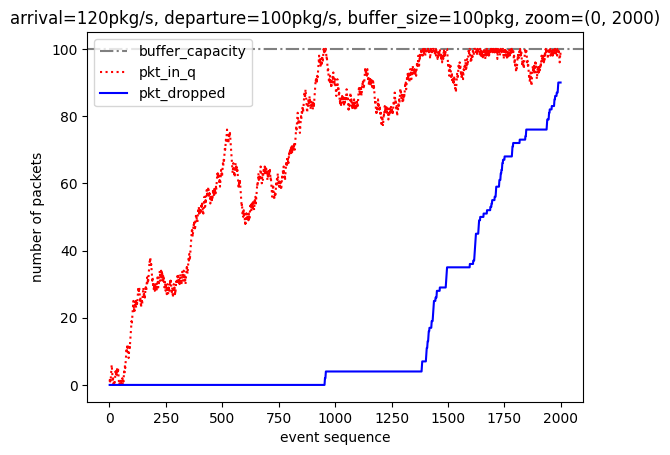

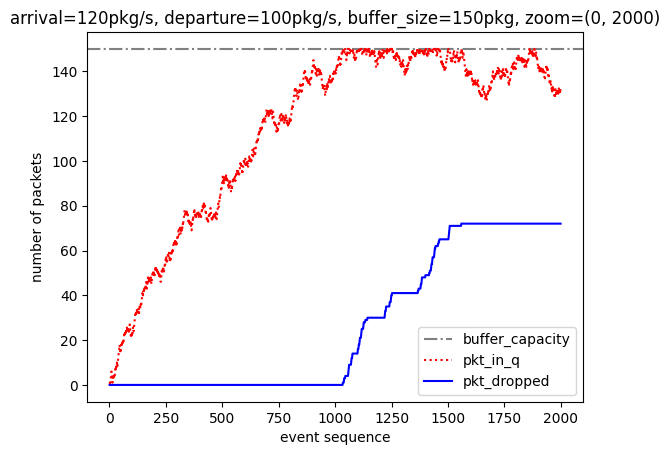

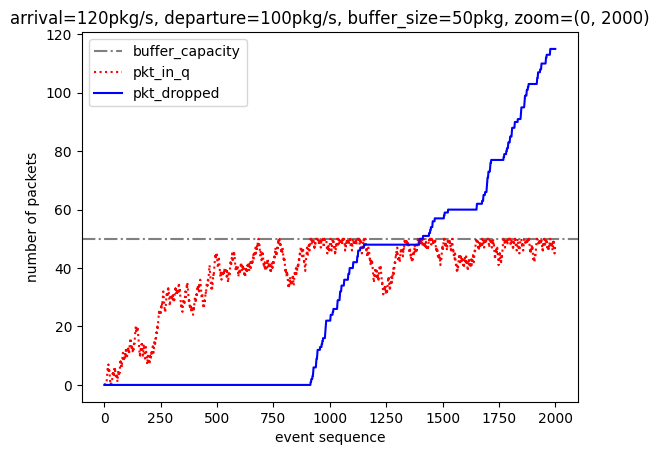

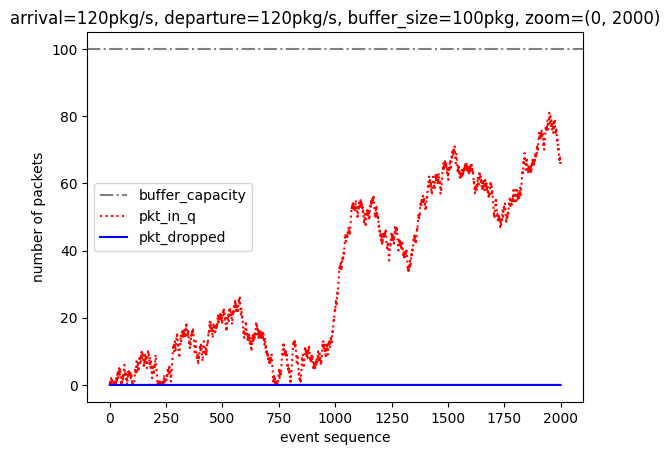

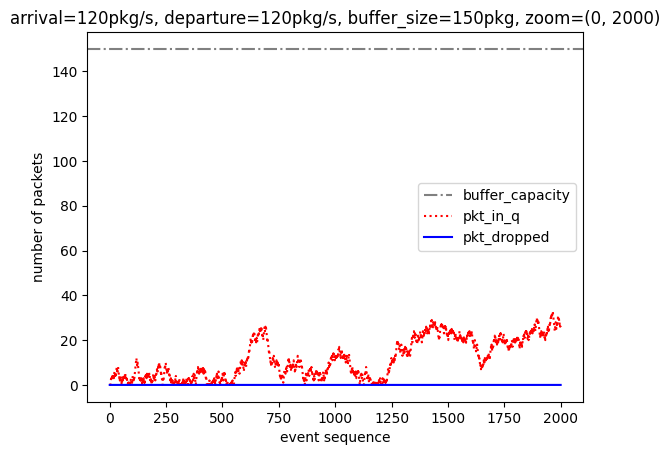

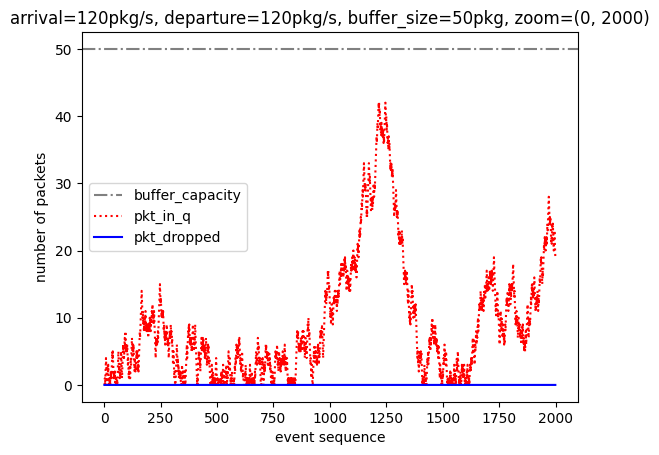

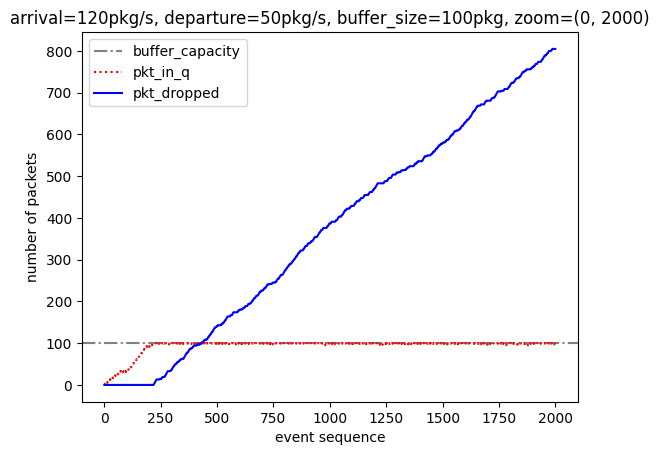

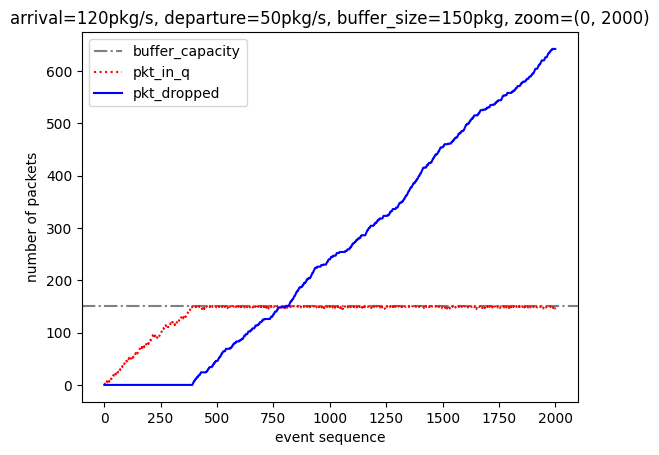

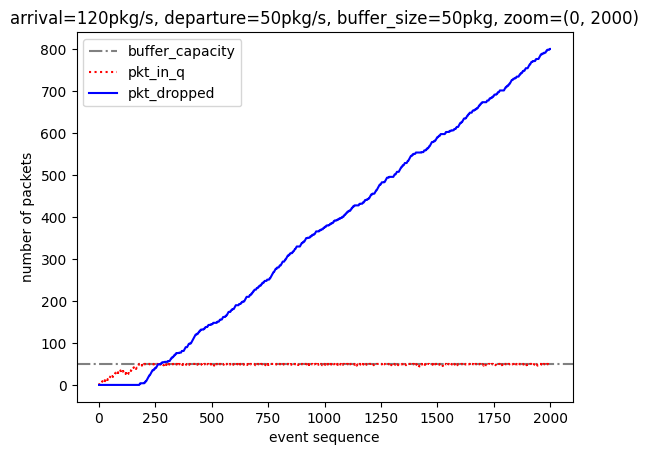

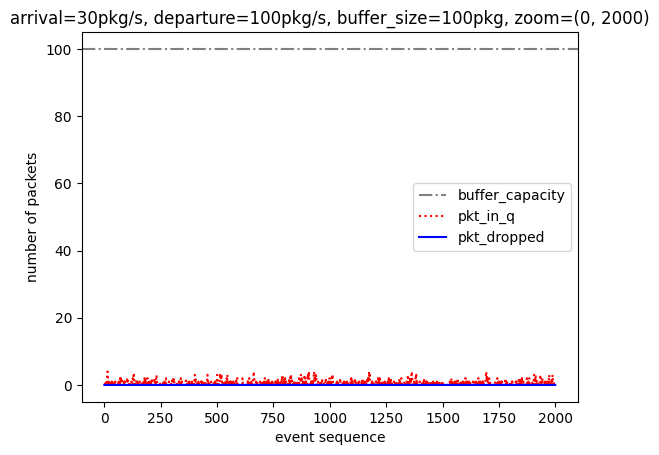

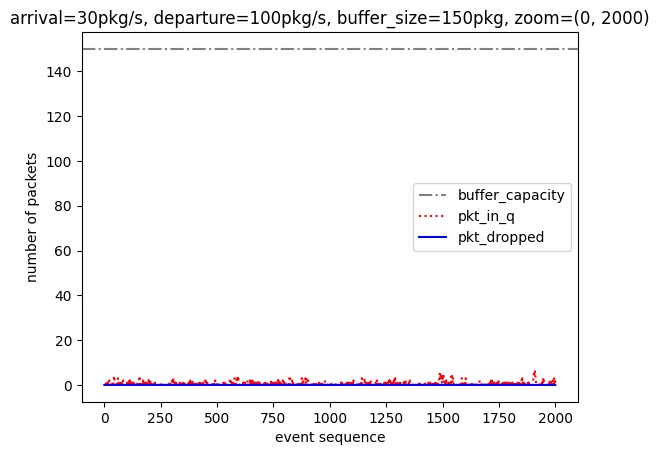

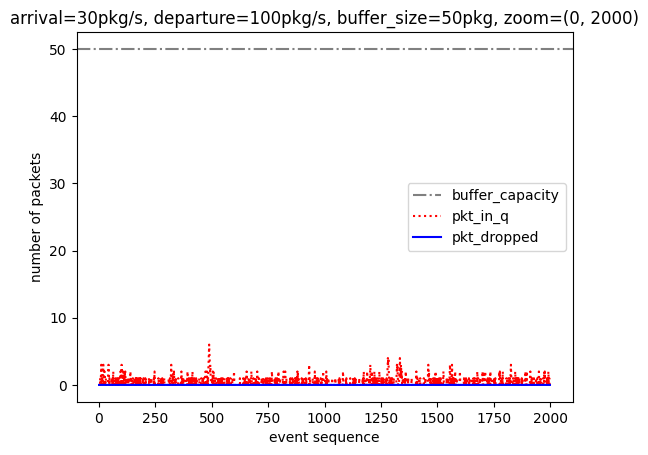

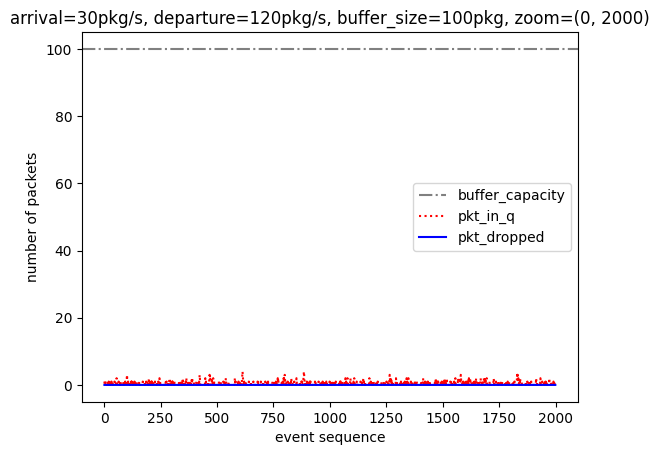

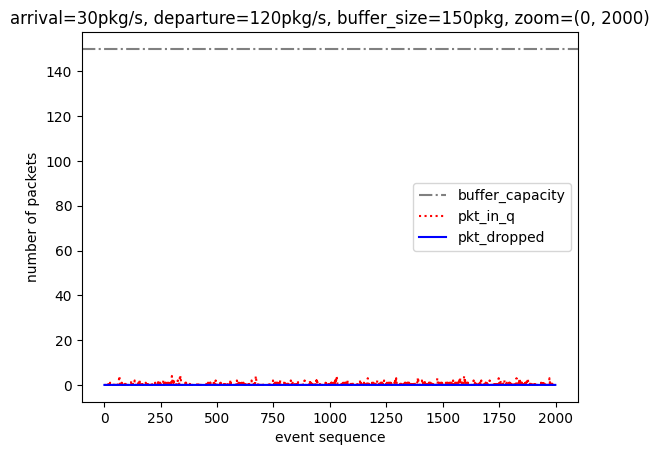

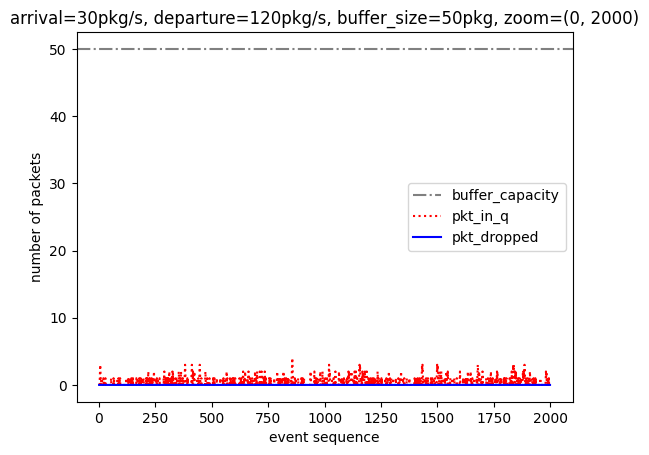

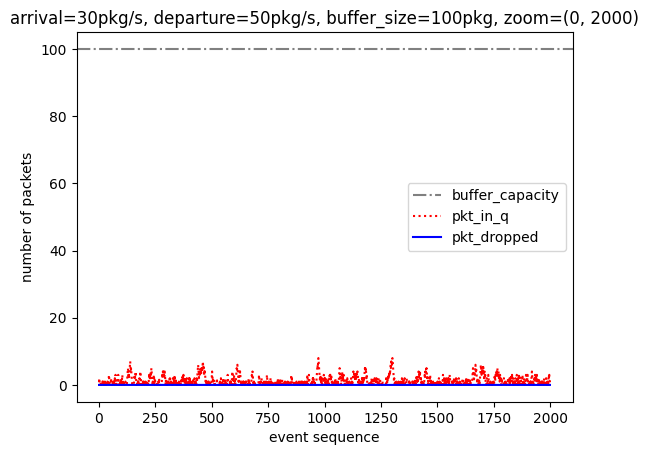

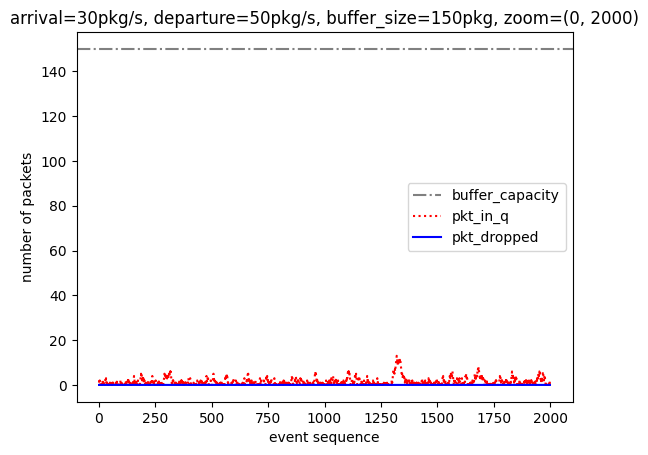

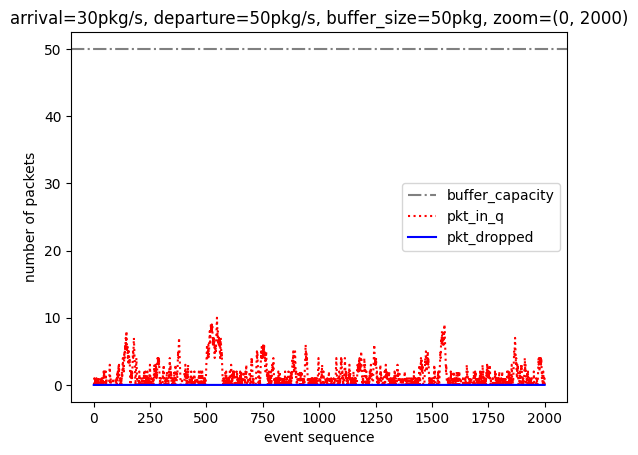

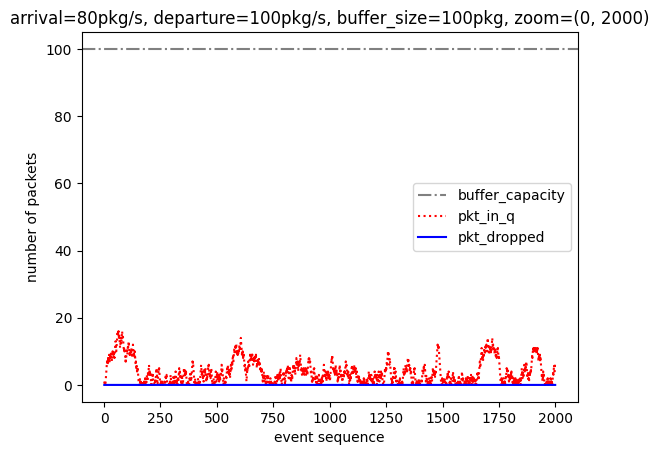

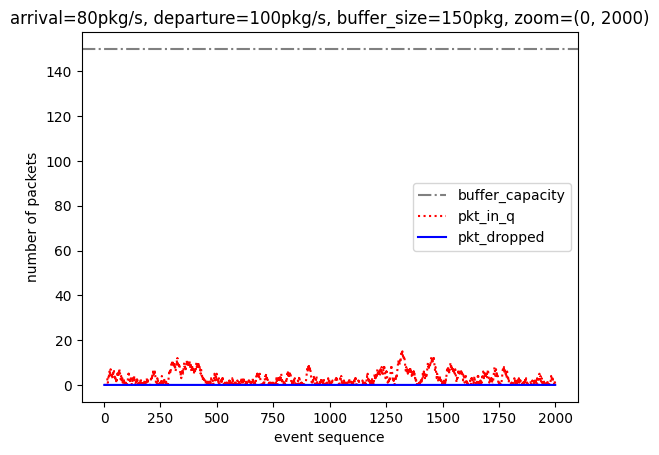

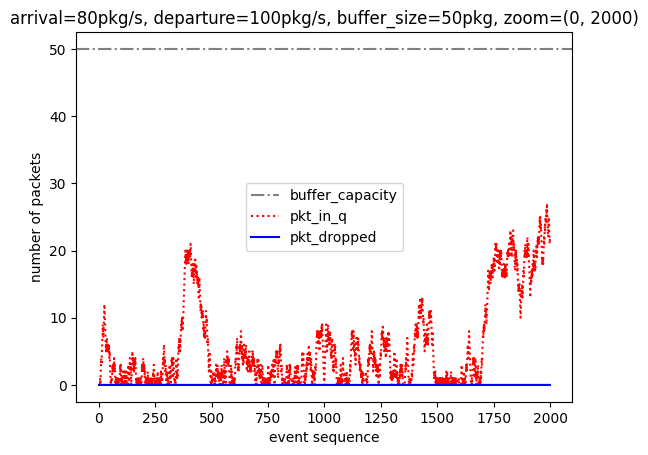

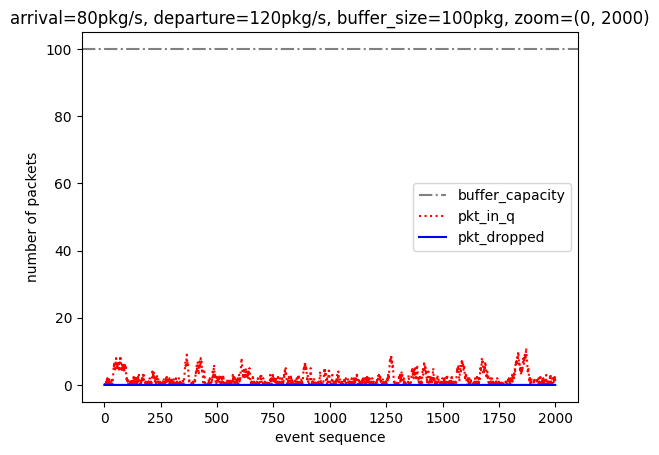

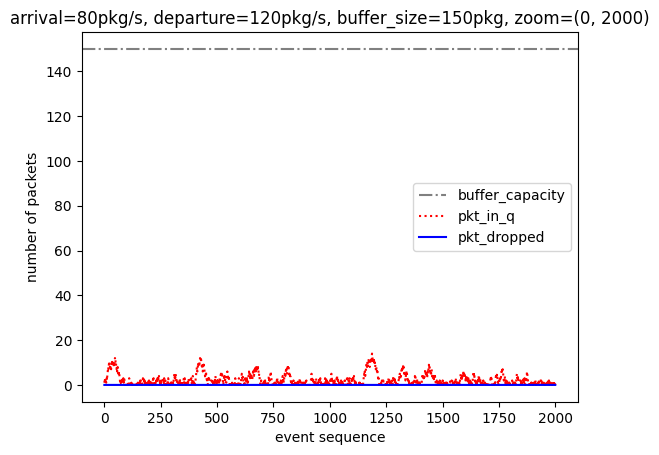

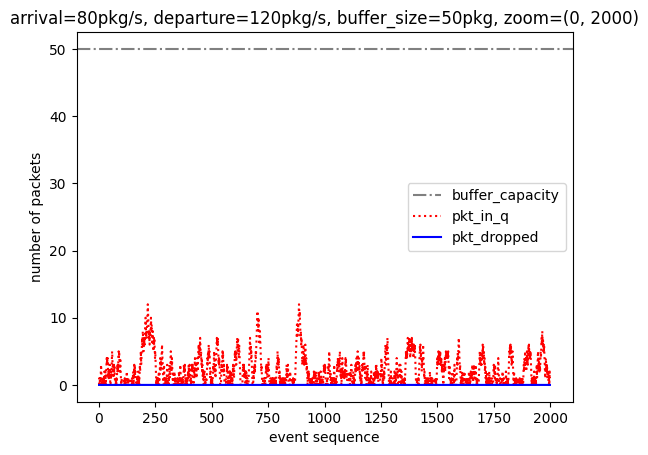

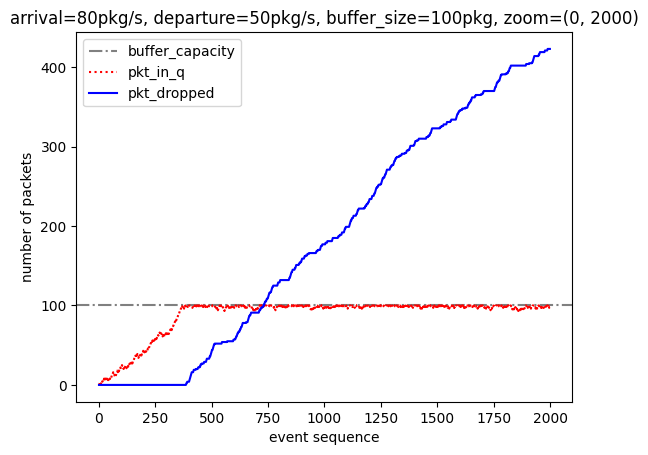

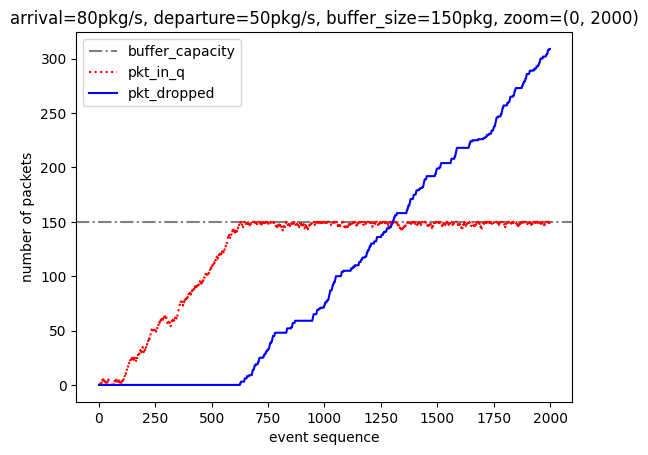

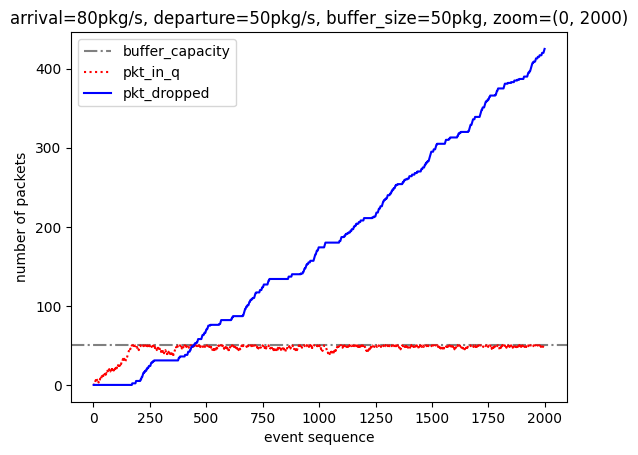

variable input rate


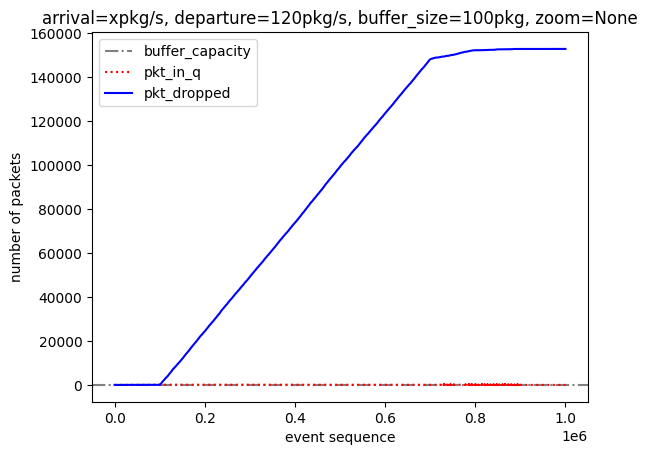

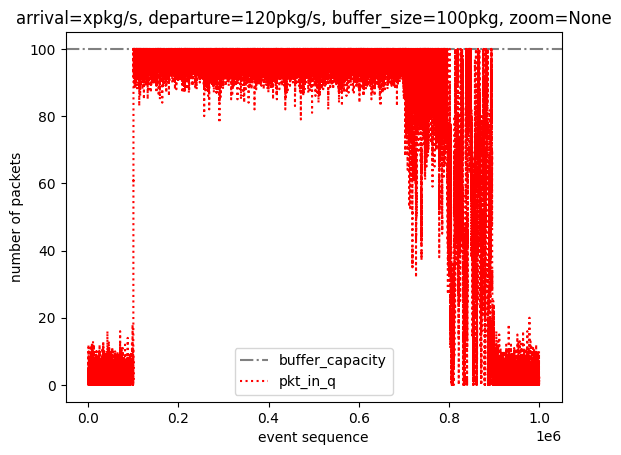

<Figure size 640x480 with 0 Axes>

In [8]:
import os

for file in os.listdir("simulated_data"):
    if file.startswith("cr"):
        plot_from_txt(file, (0,2000))
    elif file.startswith("vir"):
        print("variable input rate")
        plot_from_txt(file)
        plot_from_txt(file, show_pkg_dropped=False)

## Discussion

### Constant rate

As we can see in the plots above. When the arrival rate is higher than the departure rate, the buffer might delay the overflowing. But evnetually, the buffer will be full and the dropped packets will skyrocket.

When the arrival rate is lower than the departure rate, the buffer never reach its full capacity. 

When the arrival rate is equal to the departure rate, a bigger buffer will prevent randomly overflow. But the capcity behaviour is less predictable than the former two cases.

### Variable rate

|Events (% by range)| arrival (pkt/s)|
|-|-|
|0~10|70|
|10~70|200|
|70~80|130|
|80~90|120|
|90~100|70|

The output rate is 120 pkt/s. The input rate will exceed the output rate after 10% of the events. As the figure shows, the buffer was full and the dropped packets skyrocketed. 

Between 80% to 90% of the events, the input rate is same as the output rate. We see the buffer was still mostly full but the number of dropped packets was decreased.

After 90% of the events, the input rate is lower than the output rate. The buffer started to empty and no new packages was dropped.